# ¿How the investors select their investment portfolio?

Investors can use several approaches to analyze the potential performance of a position and the ideal time to open it in the market, but beyond the fundamental analysis, the technical analysis and the quantitative approach, there is the objective of achieve the highest possible return with the lowest possible risk, which is the purest way investors choose investments and, simultaneously, is the essence of the Modern Portfolio Theory (MPT), the main theory of the optimization process in investments.

In this sense, the MPT takes the fundamental assumptions of full rationality, optimization behavior, and historical data as the only source of information from the assets and concludes that, through the resulting benefits of diversification, the investors always will try to distribute their portfolios in the way to receive the maximum return over the minimum risk. This conclusion is far for being a simple sentence, rather it is founded over a mathematical optimization program, where the goal would be a maximization of return over a minimization of risk.

### How it works
So, in this article I will show how this logic applies in a real example. I use historical data from some stocks, in this case Apple, Amazon, Bank of America, Google and Tesla, which were downloaded through the yahoo api for the period between January of 2019 and July of 2020. Also, I have chosen the daily close price as the main indicator, the adjusted close price is more complex since it includes dividends, stock dividends, divisions and other movements that do not mean a reduction in the potential value received by investors.

My first analysis start normalizing the prices to a 100 base, so the stocks are comparable in performance. The results change from one graph to other, while the first graph shows that Amazon and Google were the stocks with the highest prices during the period, the second graph, the one with the comparable performance, shows that Tesla and Apple would returned a better yield during the period.

In [1]:
#Libraries
import pandas_datareader as pdr
import datetime
import pandas as pd
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#Stocks
stock_names = ['AAPL', 'AMZN', 'BAC', 'GOOG', 'TSLA']
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 7, 1)
stocks = pdr.DataReader(stock_names, 'yahoo',start,end)

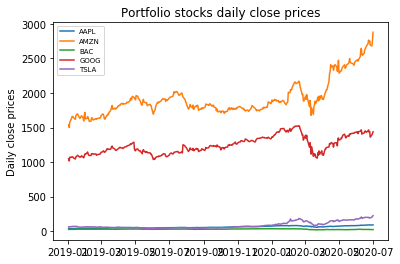

In [2]:
plt.plot(stocks.Close)
plt.legend(['AAPL', 'AMZN', 'BAC', 'GOOG', 'TSLA'], loc = 'upper left', fontsize = 7)
plt.title('Portfolio stocks daily close prices')
plt.ylabel('Daily close prices')
plt.show()

daily_return = stocks.Close.pct_change()
daily_return.iloc[0, :] = 0

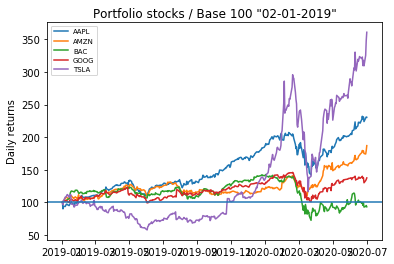

In [3]:
stocks_100 = np.ones([len(stocks), 5])*100
returns_100 = np.asarray(daily_return)

for i in range(len(stocks)-1):
    stocks_100[i+1] = stocks_100[i] * (returns_100[i+1]+1)
    i += 1 
stocks_100 = pd.DataFrame(stocks_100, index=stocks.Close.index, columns=stock_names)

plt.plot(stocks_100)
plt.axhline(y=100)
plt.legend(stocks_100.columns, loc = 'upper left', fontsize = 7)
plt.title('Portfolio stocks / Base 100 "02-01-2019"')
plt.ylabel('Daily returns')
plt.show()
plt.close()

#### Optimization Problem
So, in this case I represent the minimization of risk as the main goal of my problem, which would be expressed as minimize the covariance matrix multiplied weighted by the percentages invested in each asset, this equation subject to a level of return, that would be the risk free rate of 2%, and to the sum of the weights which must equal to 100%. Then the problem can be solved with the Lagrange Multiplier.

#### Min $$\begin{bmatrix}w1\\w2\\w3\end{bmatrix}*\begin{bmatrix}cov11&cov12&cov13\\cov21&cov22&cov23\\cov31&cov32&cov33\end{bmatrix}* \begin{bmatrix}w1&w2&w3\end{bmatrix}$$

#### Subject to
#### a)$$\begin{bmatrix}r1&r2&r3\end{bmatrix} * \begin{bmatrix}w1\\w2\\w3\end{bmatrix}= RiskFreeRate$$
#### b)$$\begin{bmatrix}w1+w2+w3+w4+w5\end{bmatrix}= 100\%$$
#### Lagrange
$$\mathcal{L}(W, h1, h2) = \begin{bmatrix}w1\\w2\\w3\end{bmatrix}@\begin{bmatrix}cov11&cov12&cov13\\cov21&cov22&cov23\\cov31&cov32&cov33\end{bmatrix}@\begin{bmatrix}w1&w2&w3\end{bmatrix} + h1(\begin{bmatrix}r1&r2&r3\end{bmatrix} @ \begin{bmatrix}w1\\w2\\w3\end{bmatrix} - RiskFreeRate) + h2(\begin{bmatrix}w1&w2&w3\end{bmatrix} @ \begin{bmatrix}1\\1\\1\end{bmatrix} - 1)$$

In [4]:
risk_free = 0.02
initial_weights = np.array([1/5,1/5,1/5,1/5,1/5])
#Matrix of returns
Returns_Matrix = np.array(daily_return[1:].mean(axis=0)).reshape(-1,1)
expected_return = Returns_Matrix.mean()
#Covariance matrix
covariance_matrix = np.array(daily_return[1:].cov())
# Ones vector
ones = np.ones((Returns_Matrix.shape[0],1))
zeros = np.zeros((2,2))

# Matrix A
A = 2*covariance_matrix
A = np.append(A, Returns_Matrix.T, axis=0)
A = np.append(A, ones.T, axis=0)
temp = np.append(Returns_Matrix, ones, axis=1)
temp = np.append(temp, zeros, axis=0)
A = np.append(A, temp, axis=1)

# Vector b
b = np.array([[0], [0], [0],[0], [0], [2.0],[1]])

##### Covariance Matrix
In this sense, the covariance matrix is and important factor, due to its properties to define in what extent the correlation between the stocks will allow to obtain diversification benefits, so the following would be the covariance matrix for the five selected stocks in this exercise

In [5]:
print(pd.DataFrame(covariance_matrix, columns = daily_return.columns, index=daily_return.columns))

Symbols      AAPL      AMZN       BAC      GOOG      TSLA
Symbols                                                  
AAPL     0.000549  0.000292  0.000466  0.000381  0.000456
AMZN     0.000292  0.000355  0.000242  0.000268  0.000339
BAC      0.000466  0.000242  0.000882  0.000399  0.000470
GOOG     0.000381  0.000268  0.000399  0.000439  0.000380
TSLA     0.000456  0.000339  0.000470  0.000380  0.001914


In this sense, the Lagrange form includes the volatility of the portfolio and the two constraints. From this point, the way to find the solution starts with the first order conditions, which outputs a system of equations that is converted to its matrx shape in A @ X = b. Since the information in the A matrix and the b vector is available, the solution will be approached finding X, which would be inv(A)@b.

#### First Order Conditions
$$\frac{\partial{L}}{\partial{W}}= 2*Covariances @Weights+h1*RiskFreeRate + h2*Ones = 0$$
$$\frac{\partial{L}}{\partial{h1}}= Weights.Transposed @ Returns - RiskFreeRate = 0$$
$$\frac{\partial{L}}{\partial{h2}}= Weights.Transposed @ Ones - 1 = 0$$
#### System of Equations
$$\begin{bmatrix}\begin{bmatrix}2*Covariances @Weights & RiskFreeRate & Ones\end{bmatrix}\\\begin{bmatrix}Weights.Transposed @ Returns&0&0\end{bmatrix}\\\begin{bmatrix}Ones.Transposed @ Returns&0&0\end{bmatrix}\end{bmatrix}
@ \begin{bmatrix}\begin{bmatrix}Weights\\h1\\h2\end{bmatrix}\end{bmatrix} = \begin{bmatrix}\begin{bmatrix}0\\RiskFreeRate\\1\end{bmatrix}\end{bmatrix}$$
#### Matrix Shape
$$A @ X = b $$
#### Solution
$$X = inverse(A) @ b $$

Once the optimization is approached, the following will be the percentages that should be invested in each stock to obtain a 2% of return during the period analyzed, this return also will be acompanied by a 14% of standard deviation, considered risk.

Note that as the restrictions mentioned allowed to go short on the stocks, the optimization to get a risk free rate would been achieved taking short positions on Amazon (0.05% short), Bank of America (20.5% short) and Google (29.4% short).

In [6]:
#Results matrix
optimization_lagrange = inv(A)@b
optimal_weights = optimization_lagrange[:daily_return[1:].shape[1]]
#Percentages
total_invested = abs(optimal_weights).sum()
percentages = optimal_weights/total_invested # The absolute value of the percentages will sum 1

print(pd.DataFrame(percentages*100, index=daily_return[1:].columns, columns=['Optimal Weights']))
optimal_return = percentages.T@Returns_Matrix*len(daily_return[1:])
optimal_risk = np.dot(percentages.T, np.dot(covariance_matrix*len(daily_return[1:]), percentages)) 
optimal_risk = np.sqrt(optimal_risk)
print('rf is: ', 2.0, 'risk is: ', optimal_risk[0][0]*100)

         Optimal Weights
Symbols                 
AAPL           40.347383
AMZN           -0.052660
BAC           -20.533756
GOOG          -29.387006
TSLA            9.679195
rf is:  2.0 risk is:  14.832039685234516


### Simulations and Shape Ratio
The optimization program above shows the minimization risk subject to the target return of the risk free rate, but as I mentioned at the beginning, the goal is to maximize return over risk, so, the way to achieve this goal is finding the best relation between return and risk, which would be the maximum return obtained by every unity of risk, this relation is similar to the Sharpe Ratio, which differs in that the Sharpe ratio measures only the return obtained over the risk free rate.
$$\frac{R}{\sigma}$$
In this sense, the way to obtain the best return risk relationship is to run simulations with the given restrictions to find the best portfolio distribution. I run 15000 simulations and graph each one of the portfolios in a scatter plot, following the Moder Portfolio Theory, and I find that the best portfolio would have achieved a ratio of 2.5 unities of return over one unity of risk. Also this portfolio would had gone short only with Bank of America and with Google. Also I backtest the strategy with a comparative graph, where the orange line represents the best return risk relationship and the blue line the risk free rate optimized portfolio. The benefits of the optimization would had given a 60% of cumulative return in the period.

In [7]:
simulations = 15000
all_weights = np.zeros((simulations, 5))

rets = np.zeros(simulations)
vols = np.zeros(simulations)
sharpe_arr = np.zeros(simulations)

for i in range(simulations): 
    weights = np.array(np.random.randn(5)) 
    weights = weights/np.sum(abs(weights))  
    
    all_weights[i,:] = weights
    
    rets[i] = np.sum((daily_return.mean()*weights)*252)

    vols[i] = np.sqrt(np.dot(weights.T,np.dot(daily_return.cov()*252, weights)))

    sharpe_arr[i] = rets[i]/vols[i]

In [21]:
print('Maximum Sharpe: ', sharpe_arr.max())
print('Weights: ', pd.Series(all_weights[sharpe_arr.argmax()]*100, index=daily_return.columns))

Maximum Sharpe:  2.517176959636961
Weights:  Symbols
AAPL    34.290657
AMZN    20.535697
BAC    -12.849384
GOOG   -23.894906
TSLA     8.429356
dtype: float64


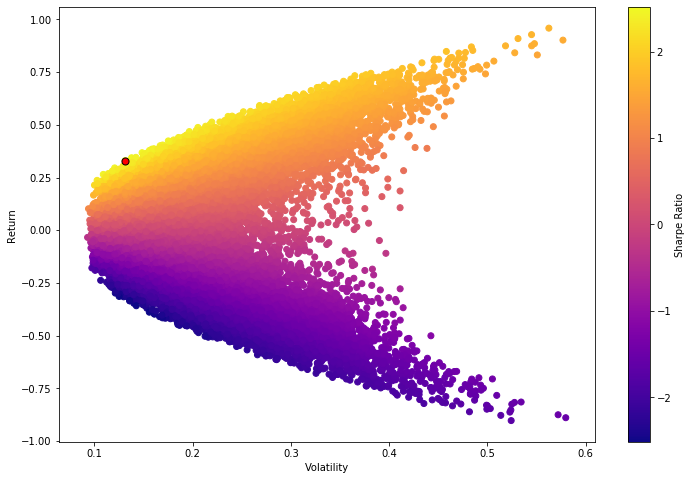

In [9]:
plt.figure(figsize=(12,8))
plt.scatter(vols,rets,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(vols[sharpe_arr.argmax()],rets[sharpe_arr.argmax()],c='red',s=50, edgecolors='black')

### Backtesting

Text(0.5, 0, 'Period')

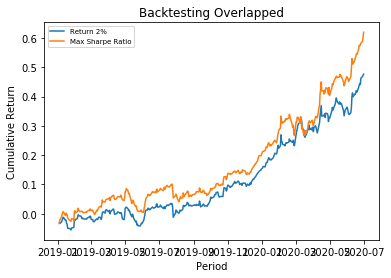

In [10]:
backtesting = pd.concat([daily_return[1:], daily_return[1:]@percentages], axis=1)
backtesting.rename({0: 'Optimal Portfolio'}, axis=1, inplace=True)

backtesting2 = pd.concat([daily_return[1:], daily_return[1:]@all_weights[sharpe_arr.argmax(), :]], axis=1)
backtesting2.rename({0: 'Optimal Portfolio'}, axis=1, inplace=True)

plt.plot(((backtesting["Optimal Portfolio"]+1).cumprod()-1))
plt.plot(((backtesting2["Optimal Portfolio"]+1).cumprod()-1))
plt.legend(["Return 2%", "Max Sharpe Ratio"], loc="upper left", fontsize=7)
plt.title("Backtesting Overlapped")
plt.ylabel("Cumulative Return")
plt.xlabel("Period")